# Pizza vs Not Pizza Binary Image Classification

## Description

- Simple Task: Is this picture a Pizza or not?
- Source from Kaggle: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data
- Subset of the Food101 Dataset: Food-101 – Mining Discriminative Components with Random Forests.
- We used the notebook from the lecture as a guide and added our own ideas to it. (https://lectures.mi.hdm-stuttgart.de/mi7sltai/)


### Dataset:
(Quick look when we download the raw files from Kaggle)

In [3]:
import os

In [5]:
pizza_folder = os.listdir('../pizza_not_pizza/pizza')
not_pizza_folder = os.listdir('../pizza_not_pizza/not_pizza')

print('Pizza Images:', len(pizza_folder), 'Not Pizza Images:', len(not_pizza_folder))

Pizza Images: 983 Not Pizza Images: 983


### Example:

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

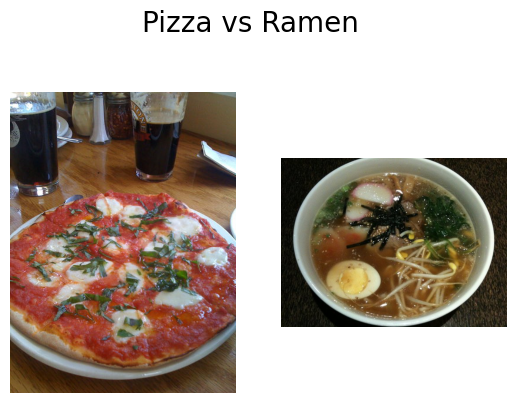

In [9]:
pizza = mpimg.imread('../pizza_not_pizza/pizza/2965.jpg')
not_pizza = mpimg.imread('../pizza_not_pizza/not_pizza/23747.jpg')

plt.subplot(1, 2, 1)
plt.imshow(pizza)
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.imshow(not_pizza)
plt.axis('off')
plt.suptitle('Pizza vs Ramen', fontsize=20)
plt.show()

### Beginning Questions/ Thoughts

- Are ~1000 images for each class enough? What influence does data augmentation have on accuracy?
- Images don't have the same size and are not split in training/validation/test
- How does a CNN perform vs a simple MLP?
- How does different hyperparameters influence the performance of the model?
- Are there any state of the art models for transfer learning which we can use? 

Bonus Question: Is the pizza from the Uni Mensa Stuttgart a pizza according to the model?

## Structure 

1. Data preparation 
2. Simple MLP 
3. CNN
4. Transfer learning
5. Conclusion

## 1. Data preparation

### 1.1 Split into training, validation and test

In [10]:
!pwd

Der Befehl "pwd" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [11]:
# show the image directory
image_path = '../pizza_not_pizza'
os.listdir(image_path)

['food101_subset.py', 'not_pizza', 'pizza']

In [12]:
# list of first pizzas
pizza_path = '../pizza_not_pizza/pizza'
os.listdir(pizza_path)[:5]

['1001116.jpg', '1008104.jpg', '1008144.jpg', '1008844.jpg', '1008941.jpg']

Split the dataset in train, valid and test folders.
Most common strategy is 80/10/10, we try this.
https://www.v7labs.com/blog/train-validation-test-set

In [14]:
# shutil for copying the files into a seperate folder, random to shuffle the files
import shutil
import random

def split_dataset(input_folder, output_folder, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1):
    
    #two folder, pizza and not pizza
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(files)

            train_split = int(train_ratio * len(files))
            validation_split = int((train_ratio + validation_ratio) * len(files))
            
            #first 80% for training files, 10% for validation and 10% for testing
            train_files = files[:train_split]
            validation_files = files[train_split:validation_split]
            test_files = files[validation_split:]

            for split, split_name in zip([train_files, validation_files, test_files], ['train', 'validation', 'test']):
                output_split_folder = os.path.join(output_folder, split_name, class_folder)
                os.makedirs(output_split_folder, exist_ok=True)

                for file_name in split:
                    source_path = os.path.join(class_path, file_name)
                    destination_path = os.path.join(output_split_folder, file_name)
                    shutil.copyfile(source_path, destination_path)


input_folder = '../pizza_not_pizza'
output_folder = '../images'

split_dataset(input_folder, output_folder)

In [15]:
# let's look at the folder structure
new_image_path = '../images'
print('Image Folder:', os.listdir(new_image_path))
print('Training Folder:',os.listdir(new_image_path+'/train'))
print('Image File:',os.listdir(new_image_path+'/train/pizza')[:1])

Image Folder: ['test', 'train', 'validation']
Training Folder: ['not_pizza', 'pizza']
Image File: ['1001116.jpg']


Now we have the desired structure. Our next step will be to create the torch data set. 

### 1.2 Create Dataset

We are first using the transforms module to define the transformations and augmentation. To get an answer to our question, we first define a simple transforms module and then a more complex one with augmentation.(https://pytorch.org/vision/stable/transforms.html).

In [16]:
from torchvision import datasets, transforms, utils

In [17]:
# only using the basic transformations
simple_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

In [18]:
#additional augmentation
additional_transforms= {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(degrees=20),
        transforms.RandomPerspective(distortion_scale=0.2,p=0.2),
        transforms.GaussianBlur(5,9),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

Now we are creating 2 datasets. One simple and one more advanced with augmentations. 

In [19]:
simple_dataset = {x: datasets.ImageFolder(os.path.join(new_image_path,x),
                  transform=simple_transforms[x])
                  for x in ['train', 'validation', 'test']}

In [20]:
advanced_dataset = {x: datasets.ImageFolder(os.path.join(new_image_path,x),
                  transform=additional_transforms[x])
                  for x in ['train', 'validation', 'test']}

Let's look at some information on the datasets.

In [21]:
advanced_dataset['train'].classes

['not_pizza', 'pizza']

In [22]:
print(advanced_dataset['train'].targets[:20])
print(advanced_dataset['train'].targets[800:820])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The dataset is not shuffled yet, the Dataloader does this later on.

In [23]:
image, label =advanced_dataset['train'][20]

RuntimeError: Calling torch.linalg.lstsq on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

In [282]:
print(label)
print(image.shape)

0
torch.Size([3, 224, 224])


To show the image with pyplot we need to swap the dimensions with permute. 

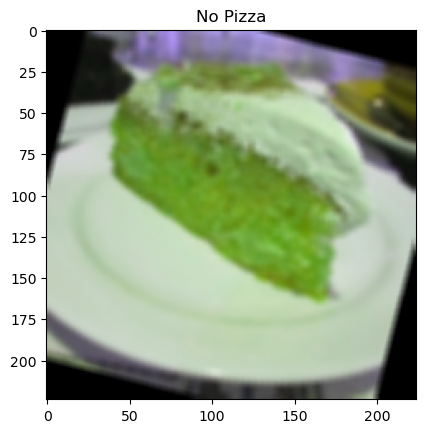

In [283]:
plt_image = image.permute(1, 2, 0).numpy()
plt.imshow(plt_image)
plt.title('No Pizza' if advanced_dataset['train'].targets[1]==0 else 'Pizza')
plt.show()

### 1.3 Create Dataloaders

No we are creating 6 Dataloaders. 3 for the simple dataset for train, validation and test. And 3 for the advanced dataset. They are being used to preprocess data for an efficient way to train model on a large dataset.

In [284]:
from torch.utils.data import DataLoader

In [285]:
#we are using the standard batch size 4 and we need to shuffle the data  
simple_dataloaders = {x: DataLoader(simple_dataset[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}

In [286]:
advanced_dataloaders = {x: DataLoader(advanced_dataset[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}

Let's show the first image batches.

In [292]:
import numpy as np

In [303]:
simple_train_imagebatch = next(iter(simple_dataloaders['train']))
advanced_train_imagebatch=next(iter(advanced_dataloaders['train']))

In [312]:
#show image batches
# the function from https://lectures.mi.hdm-stuttgart.de/mi7sltai/03_cifar10_classification_mlp_cnn.html
def my_imshow(img):
    plt.figure(figsize=(12,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

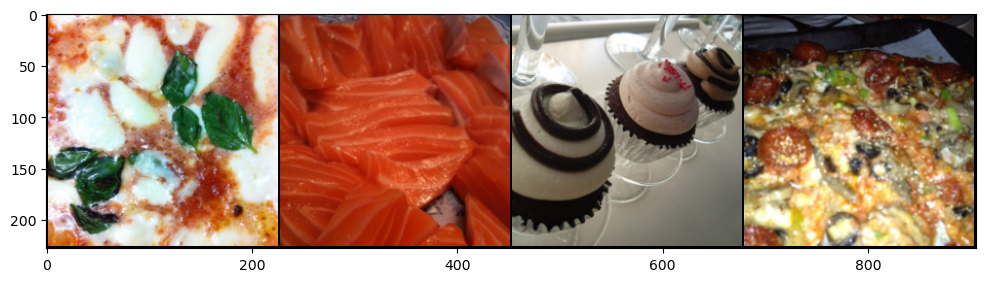

In [304]:
my_imshow(utils.make_grid(simple_train_imagebatch[0]))

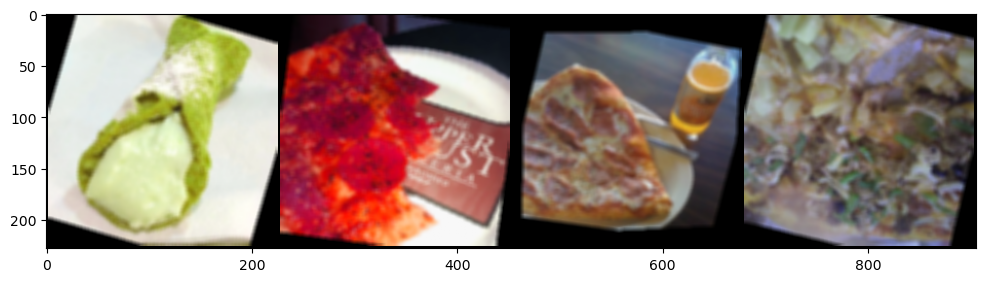

In [305]:
my_imshow(utils.make_grid(advanced_train_imagebatch[0]))

## 2. Simple MLP

To compare the result with a CNN later, we create a simple MLP.

In [343]:
import torch
import torch.nn as nn

In [410]:
#MLP Architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.d1 = nn.Linear(3 * 224 * 224, 200)
        self.d2 = nn.Linear(200, 1)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1) 
        x = self.d1(x)
        x = torch.nn.functional.relu(x)
        logits = self.d2(x)
        #sigmoid outputs between 0 and 1
        out = torch.sigmoid(logits)
        return out

We are testing the simple dataloader first and are showing the simple model.

In [386]:
model = MLP()
simple_images, simple_labels = simple_train_imagebatch
print("batch size:", simple_images.shape)
print("batch label shape", simple_labels.shape)
out = model(simple_images)
print(out)

batch size: torch.Size([4, 3, 224, 224])
batch label shape torch.Size([4])
tensor([[0.5391],
        [0.5036],
        [0.5269],
        [0.5026]], grad_fn=<SigmoidBackward0>)


In [351]:
from torchsummary import summary

In [387]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]      30,105,800
            Linear-2                    [-1, 1]             201
Total params: 30,106,001
Trainable params: 30,106,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.00
Params size (MB): 114.85
Estimated Total Size (MB): 115.42
----------------------------------------------------------------


We are creating a function for the simple MLP and to train it. 

In [388]:
from sklearn.metrics import accuracy_score

In [412]:
def train_MLP(learning_rate, num_epochs, dataloader, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        predictions_list = []
        labels_list = []

        for i, (images, labels) in enumerate(dataloader['train']):
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            # Forward + Backward + Loss
            predictions = model(images)
            labels = labels.view(-1, 1).float()
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            predictions_list.extend((predictions > 0.5).float().cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

        # Calculate and print the accuracy after each epoch
        accuracy = accuracy_score(labels_list, predictions_list)
        average_loss = running_loss / len(dataloader['train'])
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

In [413]:
model = MLP()
train_MLP(0.01,10,simple_dataloaders,model)

Epoch [1/10], Loss: 49.9828, Accuracy: 0.4987
Epoch [2/10], Loss: 50.0636, Accuracy: 0.4994
Epoch [3/10], Loss: 50.0636, Accuracy: 0.4994
Epoch [4/10], Loss: 50.0636, Accuracy: 0.4994
Epoch [5/10], Loss: 50.0636, Accuracy: 0.4994


KeyboardInterrupt: 

In [41]:


num_epochs = 10  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    predictions_list = []
    labels_list = []

    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        labels = labels.view(-1, 1).float()
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        running_loss += loss.item()

        # Collect predictions and labels for accuracy calculation
        predictions_list.extend((predictions > 0.5).float().cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

    # Calculate and print the accuracy after each epoch
    accuracy = accuracy_score(labels_list, predictions_list)
    average_loss = running_loss / len(dataloaders['train'])
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

        

Epoch [1/10], Loss: 0.6944, Accuracy: 0.5772
Epoch [2/10], Loss: 0.6853, Accuracy: 0.5936
Epoch [3/10], Loss: 0.6584, Accuracy: 0.6095
Epoch [4/10], Loss: 0.6513, Accuracy: 0.6367
Epoch [5/10], Loss: 0.6416, Accuracy: 0.6337
Epoch [6/10], Loss: 0.6358, Accuracy: 0.6567
Epoch [7/10], Loss: 0.6282, Accuracy: 0.6511
Epoch [8/10], Loss: 0.6220, Accuracy: 0.6578
Epoch [9/10], Loss: 0.6419, Accuracy: 0.6306
Epoch [10/10], Loss: 0.6392, Accuracy: 0.6537


In [42]:
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

In [43]:
# Test network

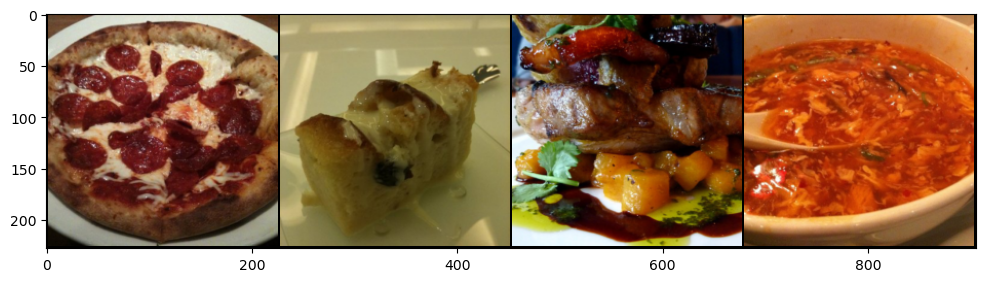

GroundTruth:  pizza not_pizza not_pizza not_pizza


In [44]:
images, labels = next(iter(dataloaders['test']))

my_imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{image_datasets["train"].classes[labels[j]]:5s}' for j in range(4)))

In [45]:
model = MLP()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [46]:
outputs = model(images)
outputs

tensor([[0.4456],
        [0.0259],
        [0.4759],
        [0.5715]], grad_fn=<SigmoidBackward0>)

In [47]:
threshold = 0.5
predictions = (outputs >= threshold).squeeze().int().tolist()

# Convert 1 to "pizza" and 0 to "not pizza"
class_labels = ["not pizza", "pizza"]
class_predictions = [class_labels[prediction] for prediction in predictions]

print(class_predictions)


['not pizza', 'not pizza', 'not pizza', 'pizza']


In [48]:
#check Uni Mensa Stuttgart Pizza

In [49]:
from PIL import Image

# Load the image
image_path = '../pizza_not_pizza/mensa_pizza.png'  # Replace with the actual path to your image
image = Image.open(image_path)

# Define the transformation
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Apply the transformation to the image
input_tensor = data_transform(image)
my_imshow(input_tensor)
# Add batch dimension to match the model's input shape
input_tensor = input_tensor.unsqueeze(0)

# Test the model
output = model(input_tensor)
print(output)
threshold = 0.5
predicted_class = "pizza" if output.item() >= threshold else "not pizza"
print(predicted_class)


FileNotFoundError: [Errno 2] No such file or directory: '../pizza_not_pizza/mensa_pizza.png'